# Import

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

import LocalProjection

# Load data

In [2]:
with open('data/data_Q.p', 'rb') as f:
    data_Q = pickle.load(f)

# Transform data

**Annualized TFP growth:**

In [3]:
data_Q['dltfp_util'] = 400*data_Q['ltfp_util'].diff(1)
data_Q['ltfp_util'] = 100*data_Q['ltfp_util']

**Trends:**

In [4]:
T = data_Q.shape[0]

data_Q['t'] = np.arange(1,T+1)
data_Q['t_sq'] = data_Q['t']**2

**Composite variables:**

In [5]:
data_Q['xtot'] = data_Q.rgdp/data_Q.tothours;
data_Q['rstockp'] = data_Q.stockp_sh/data_Q.pgdp;

data_Q['rgdp'] = data_Q.rgdp/data_Q.poplev
data_Q['rstockp'] = data_Q.rstockp/data_Q.poplev

**Log:**

In [6]:
for varname in ['rgdp','xtot','rstockp']:
    data_Q[f'log_{varname}'] = 100*np.log(data_Q[varname])

# IRFs

In [7]:
IRFs = {}
IRFs['lp'] = {}
IRFs['slp'] = {}

**Setings:**

In [8]:
# a. shock
shockname = 'dltfp_util'

# a. lists
base = ['log_rstockp','log_xtot']
rates = ['EU','UE']
#misc = ['u','RealR','Pi']

# b. combined lists
endo = ['log_rgdp', 'ltfp_util'] + rates + ['u']
contemp = ['t','t_sq'] + base #+ rates
exo = ['log_rgdp', shockname] + base #+ rates

# a. shock
#shockname = 'shock_MA'
#
# a. lists
#base = ['log_INDPRO','log_PCEPI','log_CRBCPI','u']
#rates = ['EU','UE']
#event_probs = ['EU','UE']

# b. combined lists
#endo = ['R'] + event_probs + ['u']
#contemp = base + rates
#exo = ['R',shockname] + base + rates

**Data:**

In [9]:
data_Q_IRF = data_Q[np.unique(endo+contemp+exo)] # create
data_Q_IRF = data_Q_IRF.dropna(axis=0,how='any') # remove nans
print(f'estimation period: {str(data_Q_IRF.index[0])[:-12]} to {str(data_Q_IRF.index[-1])[:-12]}')

estimation period: 1967-04 to 2015-04


**Compute:**

In [10]:
# a. settings
Nlags = 2 # lags of exogenous variables
H_min = 0 # = 0 -> recursivenes assumption
H_max = 16 # maximum horizon
r = 4 # r-1 is degree of polynomial, should be chosen by cross-validation
lambdaval = 10_000 # penalty term, should be chosen by cross-validation

# b. compute
for varname in endo + [shockname]:
    
    print(varname)
        
    # i. determine data
    # ii. regular
    lp = LocalProjection.slp(data_Q_IRF,varname,shockname,contemp,exo,
                             Nlags,H_min,H_max,smooth=True,r=r,lambdaval=1e-4)
    
    lp = LocalProjection.slp_conf(lp,H_max,lambdaval=1e-4)
    
    IRFs['lp'][varname] = lp.IRF
    IRFs['lp'][(varname,'L')] = lp.conf[:,0]
    IRFs['lp'][(varname,'U')] = lp.conf[:,1]

    # iii. smooth
    slp = LocalProjection.slp(data_Q_IRF,varname,shockname,contemp,exo,
                              Nlags,H_min,H_max,smooth=True,r=r,lambdaval=lambdaval)
    
    IRFs['slp'][varname] = slp.IRF
    

log_rgdp
ltfp_util
EU
UE
u
dltfp_util


# Figures

## Impulse-responses

### log_rgdp ###


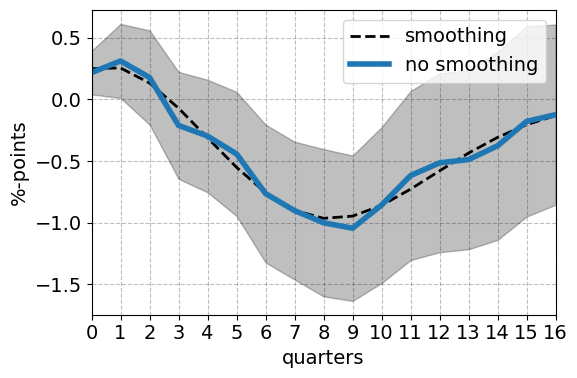

### ltfp_util ###


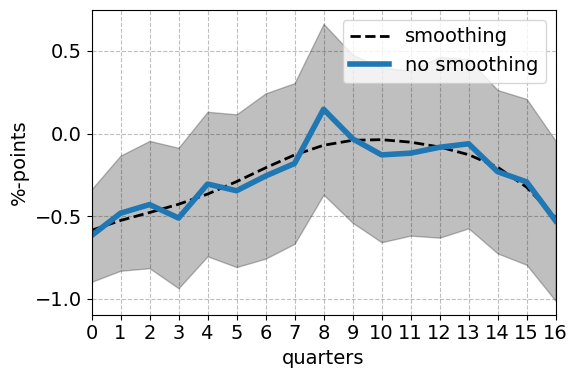

### EU ###


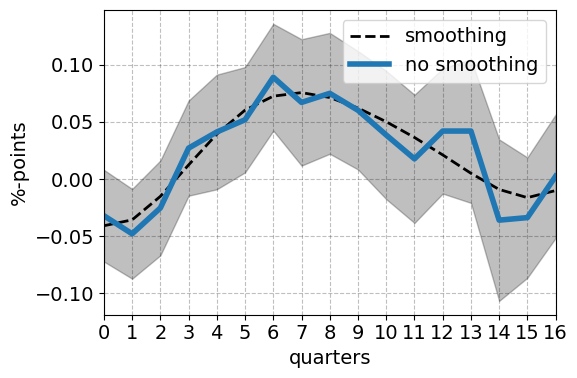

### UE ###


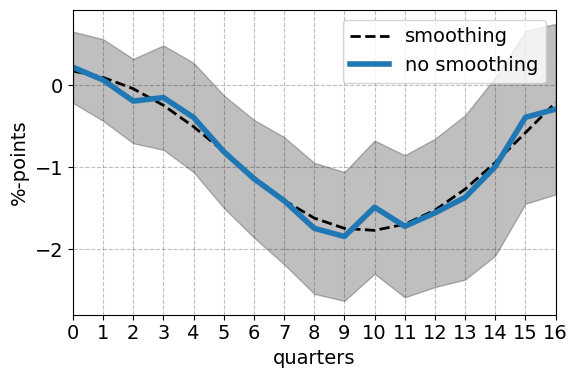

### u ###


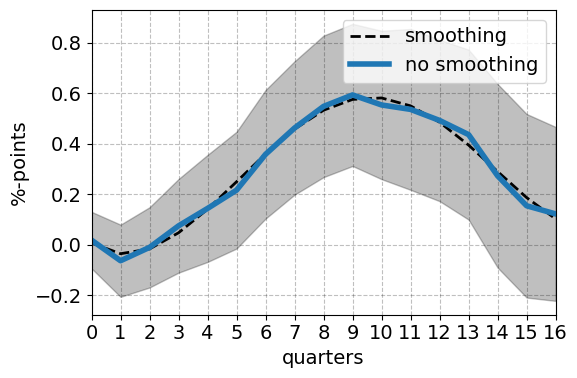

In [11]:
# a. settings
IRF = IRFs['lp']
fac = -1.0/IRF['log_rgdp'][8]

# b. plots
for varname in endo:
    
    print(f'### {varname} ###')
    
    fig = plt.figure(figsize=(6,6/1.5))
    ax = fig.add_subplot(1,1,1)

    # a. unpack
    mean = fac*IRF[varname]
    L = fac*IRF[varname,'L']
    U = fac*IRF[varname,'U']

    # b. plot
    
    # slp
    mean_slp = fac*IRFs['slp'][varname]
    ax.plot(mean_slp,lw=2,color='black',ls='--',label=fr'smoothing')
    
    # lpirfs
    ax.fill_between(np.arange(mean.size),L,U,alpha=0.25,color='black')
    ax.plot(mean,lw=4,label='no smoothing')
    
    # c. details
    ax.set_xticks(np.arange(H_max+1))
    ax.set_xlim([0,H_max])
    ax.set_xlabel('quarters')
    ax.set_ylabel('%-points')
    ax.legend(frameon=True)
    
    # d. save
    fig.tight_layout()
    fig.savefig(f'results/technology_shock_{varname}.pdf')
    plt.show()


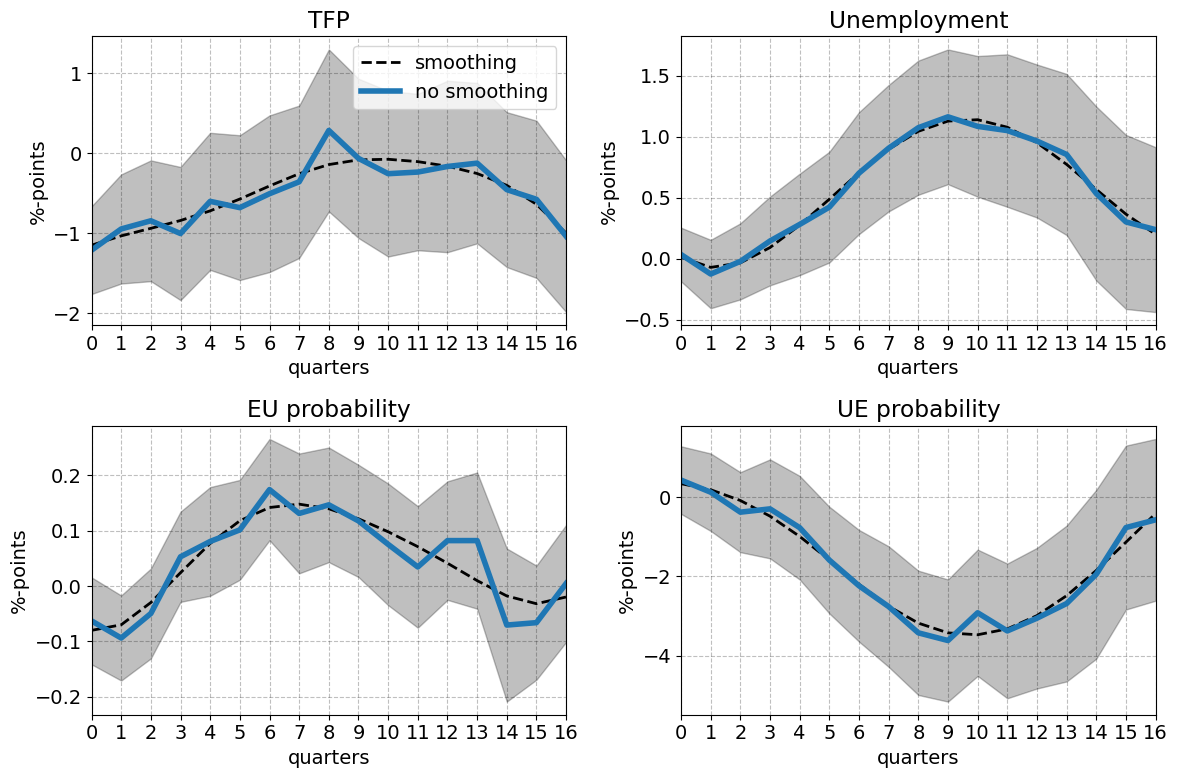

In [12]:
# a. settings
IRF = IRFs['lp']
fac = -1.0/np.mean(IRF['ltfp_util'][:4])

fig = plt.figure(figsize=(12,12/1.5))
variables = ['ltfp_util', 'u', 'EU', 'UE']
title_list = ['TFP', 'Unemployment', 'EU probability', 'UE probability']

# b. plots
for i, varname in enumerate(variables):
    ax = fig.add_subplot(2,2,i+1)

    # a. unpack
    mean = fac*IRF[varname]
    L = fac*IRF[varname,'L']
    U = fac*IRF[varname,'U']

    # b. plot
    
    # slp
    mean_slp = fac*IRFs['slp'][varname]
    ax.plot(mean_slp,lw=2,color='black',ls='--',label=fr'smoothing')
    
    # lpirfs
    ax.fill_between(np.arange(mean.size),L,U,alpha=0.25,color='black')
    ax.plot(mean,lw=4,label='no smoothing')
    
    # c. details
    ax.set_xticks(np.arange(H_max+1))
    ax.set_xlim([0,H_max])
    ax.set_xlabel('quarters')
    ax.set_ylabel('%-points')
    ax.set_title(title_list[i])
    if i==0:
        ax.legend(frameon=True)
    
# d. save
fig.tight_layout()
fig.savefig(f'results/technology_shock_subplot.pdf')
plt.show()

## IRFs in levels

In [13]:
ss_EU = np.mean(data_Q_IRF['EU'])
ss_UE = np.mean(data_Q_IRF['UE'])
ss_u = 100*ss_EU/(ss_EU+ss_UE)

IRF_u = ss_u + fac*IRFs['slp']['u']
IRF_EU = ss_EU + fac*IRFs['slp']['EU']
IRF_UE = ss_UE + fac*IRFs['slp']['UE']

## Lead-Lag

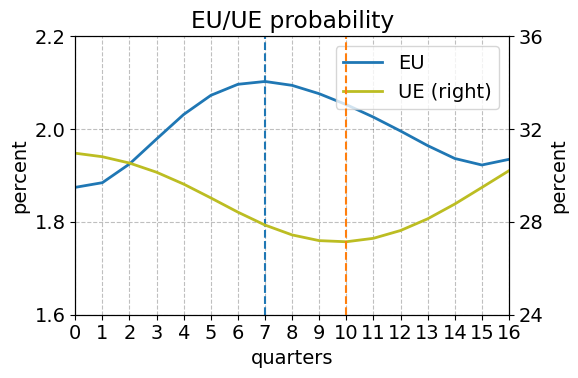

In [14]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)

# left
ax.plot(IRF_EU,lw=2,color=colors[0],label=f'EU')
ax.axvline(np.argmax(IRF_EU),ls='--',color=colors[0])

# right
ax.plot(np.nan*np.ones(1),lw=2,color=colors[-2],label=f'UE (right)')

ax_r = ax.twinx()
ax_r.plot(IRF_UE,color=colors[-2],lw=2)
ax_r.axvline(np.argmin(IRF_UE),ls='--',color=colors[1])
ax_r.grid(None)

# y-axis
ax.set_yticks(np.arange(1.6,2.2,0.2))
ax.set_ylim([1.6,2.2])
ax.set_ylabel('percent')

ax_r.set_yticks(np.arange(24,37,4))
ax_r.set_ylim([24,36])
ax_r.set_ylabel('percent')

# x-axis
ax.set_xticks(np.arange(H_max+1))
ax.set_xlim([0,H_max])
ax.set_xlabel('quarters')
ax.set_title('EU/UE probability')

# save
ax.legend(frameon=True,loc=1)
fig.tight_layout()
fig.savefig(f'results/technology_shock_lead_lag.pdf')
plt.show()

## Approximation error

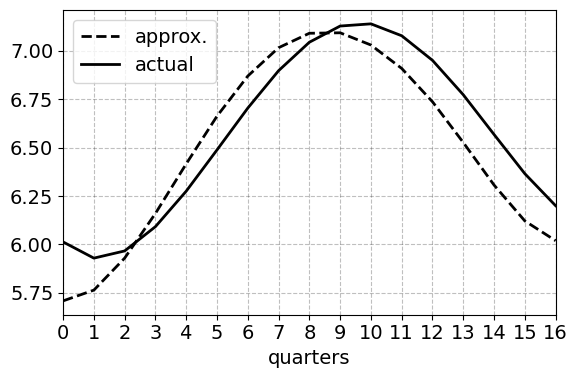

In [15]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)

ax.plot(100*IRF_EU/(IRF_EU+IRF_UE),color='black',ls='--',lw=2,label=fr'approx.')
ax.plot(IRF_u,color='black',lw=2,label=f'actual')


# y-axis
ax.set_xlabel('percent')

# x-axis
ax.set_xticks(np.arange(H_max+1))
ax.set_xlim([0,H_max])
ax.set_xlabel('quarters')

# save
ax.legend(frameon=True)
fig.tight_layout()
fig.savefig(f'results/technology_shock_approx_error.pdf')
plt.show()

## Decomposition

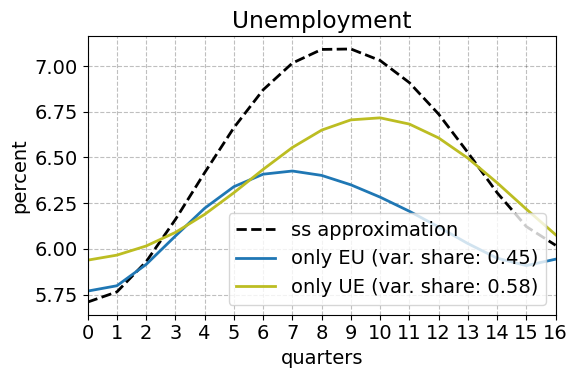

In [16]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)

u_approx = 100*IRF_EU/(IRF_EU+IRF_UE)
u_EU = 100*IRF_EU/(IRF_EU+ss_UE)
u_UE = 100*ss_EU/(ss_EU+IRF_UE)

var_share_u_EU = np.cov(u_approx.T,u_EU.T)[0,1]/np.var(u_approx)
var_share_u_UE = np.cov(u_approx.T,u_UE.T)[0,1]/np.var(u_approx)

ax.plot(u_approx,color='black',lw=2,ls='--',label=fr'ss approximation')

ax.plot(u_EU,color=colors[0],lw=2,label=f'only EU (var. share: {var_share_u_EU:.2f})')
ax.plot(u_UE,color=colors[-2],lw=2,label=f'only UE (var. share: {var_share_u_UE:.2f})')

ax.legend(frameon=True)
ax.set_xticks(np.arange(H_max+1))
ax.set_xlim([0,H_max])
ax.set_xlabel('quarters')
ax.set_ylabel('percent')
ax.set_title('Unemployment')

# save
ax.legend(frameon=True)
fig.tight_layout()
fig.savefig(f'results/technology_shock_decomposition.pdf')
plt.show()

In [17]:
with open('saved/technology_IRF.pickle', 'wb') as f:
    pickle.dump({'u_approx':u_approx,'u_EU':u_EU,'u_UE':u_UE,'var_share_u_EU':var_share_u_EU,'var_share_u_UE':var_share_u_UE},f)